In [118]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

In [131]:
dat = sw.Data(delta=0.1, noise=0.01, split=(30, 1.3))
x0 = dat.x
y0 = dat.y

The correlation and the variance of the data are connected by the covariance.

The Pearson correlation coefficient $\rho$, is maximised between the *fast* and *slow* components when the data are corrected for splitting.
$\rho(X,Y) = \frac{\operatorname{cov}(X,Y)}{\sigma_{X}\sigma_{Y}}$

The variance.  This is equivalent to the energy.  The energy is maximised on the *polarisation* component and minimised on the *transverse* component when the data are corrected for splitting.
$\operatorname{var}(X) = \operatorname{cov}(X,X)$

The covariance is defined as:
$\operatorname{cov}(X,Y) = \operatorname {E} [(X-\operatorname{E}[X])(Y-\operatorname{E}[Y])]$, or calculated using:
$cov(X,Y) = \frac{1}{n} \Sigma^{n}_{i=1}(x_i - \mu_x)(y_i - \mu_y)$

The variance-covariance matrix:
$\Sigma _{ij}=\operatorname {cov} (X_{i},X_{j})=\operatorname {E} [(X_{i}-\mu _{i})(X_{j}-\mu _{j})]=\operatorname {E} [X_{i}X_{j}]-\mu _{i}\mu _{j}$




In [221]:
def rotate(x,y,degrees):
    """row 0 is x-axis and row 1 is y-axis,
       rotates from x to y axis
       e.g. N to E if row 0 is N cmp and row1 is E cmp"""
    ang = math.radians(degrees)
    rot = np.array([[ np.cos(ang), np.sin(ang)],
                    [-np.sin(ang), np.cos(ang)]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def get_c(dx, dy):
    c = np.empty((2, 2))
    c[0][0] = np.sum(dx**2)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    c[1][1] = np.sum(dy**2)
    return c / (np.sqrt(c[0][0]) * np.sqrt(c[1][1]))

def slagchop(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d] 

def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

def rotmat(ang):
    sang = math.sin(ang)
    cang = math.cos(ang)
    return np.array([[ cang, sang],
                    [-sang, cang]])

# slower
# def running_mean2(x, w0, w1, maxslag):
#     d = int(maxslag/2)
#     x = x[w0-d: w1+d]
#     n = w1-w0
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     return (cumsum[n:] - cumsum[:-n]) / float(n)


In [206]:
degs = np.linspace(0, 180, 180, endpoint=False)
lags = np.linspace(0, 8, 60)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))

def gridcov(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov


    

In [207]:
x, y, w0, w1 = dat.x, dat.y, dat._w0(), dat._w1()

In [276]:
c = gridcov(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# silver and chan transenergy method
pol = 0
var = np.empty(c.shape)
# rotmats = np.asarray([ rotmat(math.radians(pol-deg)) for deg in degs ])
# var = np.tensordot(c, rotmats, 2)
for ii in range(degs.size):
    r = rotmat(math.radians(pol-degs[jj]))
    for jj in range(slags.size):
        var[ii,jj,:,:] = np.dot(r, c[ii,jj,:,:])
        
var1 = var[:,:,0,0]
var2 = var[:,:,1,1]



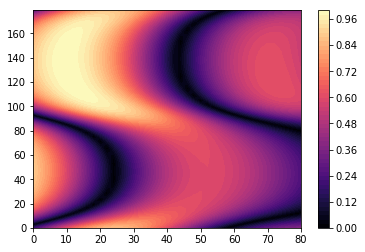

In [199]:
ll, dd = np.meshgrid(slags, degs)
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()


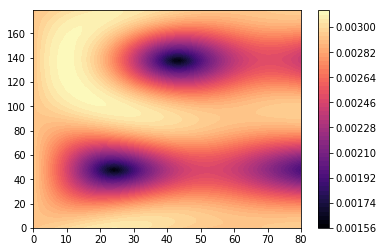

In [195]:
ll, dd = np.meshgrid(slags, degs)
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

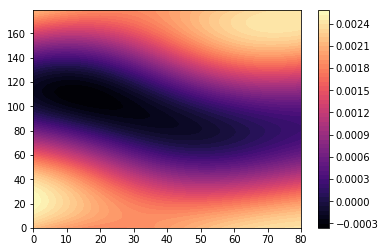

In [280]:
ll, dd = np.meshgrid(slags, degs)
plt.contourf(ll, dd, var1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [237]:
np.broadcast_to(rotmats, (180, 2, 2, 41))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (180,2,2) and requested shape (180,2,2,41)

In [209]:
c[:,:,0,0].shape

(180, 41)

In [19]:
dat._w0() - 2/2

329.0

In [18]:
dat._w1()

659

In [28]:
np.convolve?

In [156]:
eigvals, eigvecs = np.linalg.eigh(c[:,:])

In [163]:
eigvals[:,:,0]

array([[ 0.00017179,  0.00016396,  0.00014071, ...,  0.00015749,
         0.00015389,  0.00015304],
       [ 0.00017179,  0.0001686 ,  0.00015333, ...,  0.00015984,
         0.00015618,  0.00015501],
       [ 0.00017179,  0.00017333,  0.00016662, ...,  0.00016693,
         0.00016358,  0.00016227],
       ..., 
       [ 0.00017179,  0.00015074,  0.00010718, ...,  0.00017784,
         0.00017654,  0.00017781],
       [ 0.00017179,  0.00015501,  0.00011762, ...,  0.00016665,
         0.00016423,  0.0001646 ],
       [ 0.00017179,  0.00015943,  0.0001288 , ...,  0.00015981,
         0.00015661,  0.00015629]])

In [205]:
degs = np.linspace(0, 180, 90, endpoint=False)
lags = np.linspace(0, 8, 30)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))
%timeit gridcov(x, y, w0, w1, degs, slags)

66.6 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [255]:
# a = np.broadcast_to(rotmats, (41, 180, 2, 2))
# b = np.swapaxes(a, 0, 1)
# b.shape
np.dot(a, c[:,:]).shape

(41, 180, 2, 180, 41, 2)

In [217]:
c[0,:].shape

(41, 2, 2)

In [241]:
rotmats.shape

(180, 2, 2)

In [239]:
>>> x = np.array([1, 2, 3])
>>> np.broadcast_to(x, (3, 3))


array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [244]:
x = np.arange(9).reshape((3,3))

In [273]:
rotmats.shape

(180, 2, 2)

In [ ]:
def gridcov_srccorr(x, y, w0, w1, degs, slags, srcfast, srcslag):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov